In [9]:
import os
import re
import sys
import time
import pickle
import math
import random
import string
import collections
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from .highway import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 0
print(device)

cuda


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [11]:
trainset = torchvision.datasets.CIFAR10(root=' ', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root=' ', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=1)

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:01, 88915699.86it/s]                               


Extracting  /cifar-10-python.tar.gz to  
Files already downloaded and verified


In [0]:
filtersize = 64

In [0]:
class HighwayNet(nn.Module):
  def __init__(self):
    super(HighwayNet,self).__init__()
    self.channels = 3
    self.filtersize = filtersize
    self.conv1 = nn.Conv2d(self.channels,self.filtersize,3)
    self.high1 = Conv2DHighwayLayer(self.filtersize,self.filtersize,3)
    self.high2 = Conv2DHighwayLayer(self.filtersize,self.filtersize,3)
    self.high3 = Conv2DHighwayLayer(self.filtersize,self.filtersize,3)
    self.flatten = nn.Flatten(1,-1)
    self.fc1 = nn.Linear(576,128)
    self.fc2 = nn.Linear(128,10)
  
  def forward(self,x):
    x = F.relu(self.conv1(x))
    out = self.high1(x)
    out = F.max_pool2d(out,kernel_size=(2,2))
    out = self.high2(out)
    out = F.max_pool2d(out,kernel_size=(2,2))
    out = self.high3(out)
    out = F.max_pool2d(out,kernel_size=(2,2))
    out = self.flatten(out)
    out = F.relu(self.fc1(out))
    out = F.dropout(out,0.3)
    out = self.fc2(out)
    return out

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.channels = 3
    self.filtersize = filtersize
    self.conv1 = nn.Conv2d(self.channels,self.filtersize,3)
    self.conv2 = nn.Conv2d(self.filtersize,self.filtersize,3)
    self.conv3 = nn.Conv2d(self.filtersize,self.filtersize,3)
    self.conv4 = nn.Conv2d(self.filtersize,self.filtersize,3)
    self.flatten = nn.Flatten(1,-1)
    self.fc1 = nn.Linear(256,64)
    self.fc2 = nn.Linear(64,10)
  
  def forward(self,x):
    x = F.relu(self.conv1(x))
    out = self.conv2(x)
    out = F.max_pool2d(out,kernel_size=(2,2))
    out = self.conv3(out)
    out = F.max_pool2d(out,kernel_size=(2,2))
    out = self.conv4(out)
    out = F.max_pool2d(out,kernel_size=(2,2))
    out = self.flatten(out)
    out = F.relu(self.fc1(out))
    out = F.dropout(out,0.3)
    out = self.fc2(out)
    return out

In [0]:
def evaluate(net,loader):
  correct = 0.0
  total = 0.0
  curloss = 0.0
  with torch.no_grad():
    net.eval()
    for images,labels in loader:
      images, labels = images.to(device), labels.to(device)
      output = net(images)
      l = F.cross_entropy(output,labels)
      output = torch.argmax(output,1)
      total+=output.size(0)
      correct+=(output==labels).sum().item()
      curloss+=l.item()

    curloss = curloss/total
    acc = (correct/total) * 100
    return round(curloss,4),round(acc,3)

In [0]:
numepochs = 200

In [58]:
np.random.seed(seed)
torch.manual_seed(seed)

model1_train_loss = []
model1_train_acc = []
model1 = Net().to(device)
optim1 = optim.Adam(model1.parameters(),lr=0.0003)
model1.train()
print("Training Neural Network with No Highway Layers")
print("------------------------------------------------------------------------------")
for epoch in range(1,numepochs+1):
  model1.train()
  for images,labels in trainloader:
    images,labels = images.to(device),labels.to(device)
    model1.zero_grad()
    output = model1(images)
    loss = F.cross_entropy(output,labels)
    loss.backward()
    optim1.step()

  curtrainloss, curtrainacc = evaluate(model1,trainloader)
  if(epoch%10==0):
    print("Epoch {} Train Loss {} Train Accuracy {} ".format(epoch,curtrainloss,curtrainacc))
  model1_train_loss.append(curtrainloss)
  model1_train_acc.append(curtrainacc)

curtestloss, curtestacc = evaluate(model1,testloader)
print("Model 1 (Without Highway Layers) Test Accuracy {} ".format(curtestacc))
print("------------------------------------------------------------------------------")
print("------------------------------------------------------------------------------")
print("Training Neural Network with Highway Layers ")
model2_train_loss = []
model2_train_acc = []
model2 = HighwayNet().to(device)
optim2 = optim.Adam(model2.parameters(),lr=0.003)
model2.train()
for epoch in range(1,numepochs+1):
  model2.train()
  for images,labels in trainloader:
    images,labels = images.to(device),labels.to(device)
    model2.zero_grad()
    output = model2(images)
    loss = F.cross_entropy(output,labels)
    loss.backward()
    optim2.step()

  curtrainloss, curtrainacc = evaluate(model2,trainloader)
  if(epoch%10==0):
    print("Epoch {} Train Loss {} Train Accuracy {} ".format(epoch,curtrainloss,curtrainacc))
  model2_train_loss.append(curtrainloss)
  model2_train_acc.append(curtrainacc)

curtestloss, curtestacc = evaluate(model2,testloader)
print("Model 2 (With Highway Layers) Accuracy {} ".format(curtestacc))

Training Neural Network with No Highway Layers
------------------------------------------------------------------------------
Epoch 10 Train Loss 0.0082 Train Accuracy 71.332 
Epoch 20 Train Loss 0.0059 Train Accuracy 79.154 
Epoch 30 Train Loss 0.0048 Train Accuracy 82.564 
Epoch 40 Train Loss 0.0037 Train Accuracy 86.468 
Epoch 50 Train Loss 0.003 Train Accuracy 89.166 
Epoch 60 Train Loss 0.0025 Train Accuracy 90.812 
Epoch 70 Train Loss 0.0021 Train Accuracy 92.334 
Epoch 80 Train Loss 0.0017 Train Accuracy 93.924 
Epoch 90 Train Loss 0.0015 Train Accuracy 94.472 
Epoch 100 Train Loss 0.0013 Train Accuracy 95.1 
Epoch 110 Train Loss 0.0012 Train Accuracy 95.576 
Epoch 120 Train Loss 0.0011 Train Accuracy 95.932 
Epoch 130 Train Loss 0.0011 Train Accuracy 96.006 
Epoch 140 Train Loss 0.0011 Train Accuracy 96.114 
Epoch 150 Train Loss 0.0009 Train Accuracy 96.818 
Epoch 160 Train Loss 0.0009 Train Accuracy 96.776 
Epoch 170 Train Loss 0.0008 Train Accuracy 97.064 
Epoch 180 Train Los

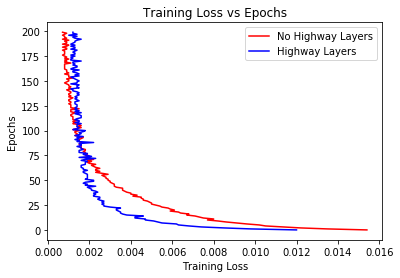

In [59]:
iterations = list(range(numepochs))
plt.plot(model1_train_loss, iterations, 'r', label='No Highway Layers') # plotting model1 train loss separately 
plt.plot(model2_train_loss, iterations, 'b', label='Highway Layers') # plotting model2 train loss separately 
plt.xlabel('Training Loss')
plt.ylabel('Epochs')
plt.title('Training Loss vs Epochs')
plt.legend()
plt.show()

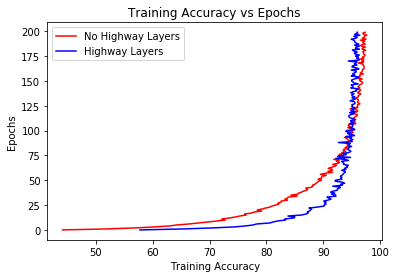

In [60]:
plt.plot(model1_train_acc, iterations, 'r', label='No Highway Layers') # plotting model1 train accuracy separately 
plt.plot(model2_train_acc, iterations, 'b', label='Highway Layers') # plotting model2 train accuracy separately 
plt.legend()
plt.xlabel('Training Accuracy')
plt.ylabel('Epochs')
plt.title('Training Accuracy vs Epochs')
plt.show()